# Mushroom Dataset Distribution and Cleaning

## Raw Dataset Distribution 

In [125]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import torch

In [142]:
# get data about classes from each of the labels
test_label_path = "data/Mushrooms100.v16-dataset-14-types-2.yolov8/test/labels/*"
valid_label_path = "data/Mushrooms100.v16-dataset-14-types-2.yolov8/valid/labels/*"
train_label_path = "data/Mushrooms100.v16-dataset-14-types-2.yolov8/train/labels/*"
class_labels = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13'] 

In [140]:
def load_data_for_count(file_path, label_list):
    count = 0
    data_output = []
    for item in glob.glob(file_path):
        file_name = os.path.basename(item)
        folder_path = file_path.strip('*')
        file_location = folder_path + file_name
        file_data = open(file_location, "r")
        for line in file_data:
            line.split()
            data = line.split(' ')
            mush_class = data[0]
            data_output.append(mush_class)
    return np.array(data_output)


In [144]:
def count_dict(array, to_dict):
    for item in array:
        if item in to_dict:
            to_dict[item] += 1
        else:
            to_dict[item] = 1
    return to_dict
    

In [146]:
test_class_labels=load_data_for_count(test_label_path, class_labels)
val_class_labels=load_data_for_count(valid_label_path, class_labels)
train_class_labels=load_data_for_count(train_label_path, class_labels)

In [151]:
class_dict = {}
class_dict = count_dict(test_class_labels, class_dict)
class_dict = count_dict(val_class_labels, class_dict)
class_dict = count_dict(train_class_labels, class_dict)

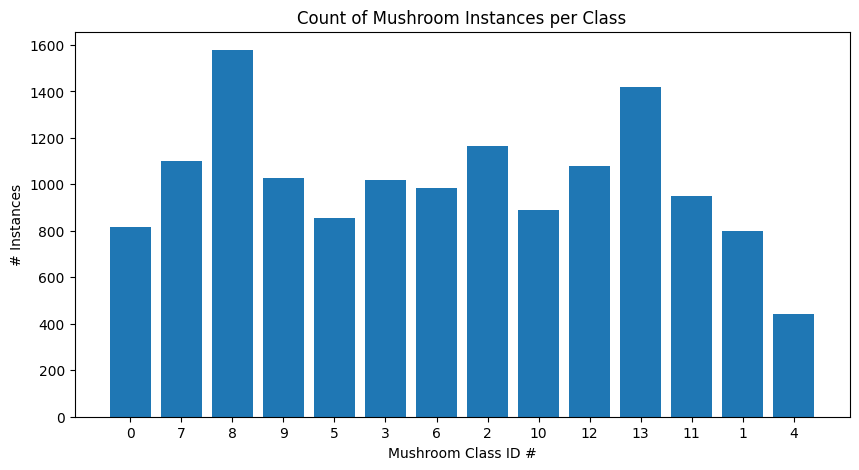

In [150]:
mushroom_class = list(class_dict.keys())
sample_count = list(class_dict.values())

fig = plt.figure(figsize=(10, 5))
plt.bar(mushroom_class, sample_count)
plt.xlabel("Mushroom Class ID #")
plt.ylabel("# Instances")
plt.title("Count of Mushroom Instances per Class")
plt.show()